This is an idea to use co-aggregation data to generate an offspring distribution, which can the be used with the theory of Galton-Watson Branching Processes.

---

Co-aggregation is the phenomenon where larval and nymphal ticks co-feed on the same relatively small number of vertebrate hosts; the 80:20 rule is frequently found to be a good description of tick aggregation.

Co-aggregation on a single vertebrate host can be thought of as a bipartite graph. The work by Johnstone-Robertson and others showed that if we treat each vertebrate host as a node, then the degree $ d_{in} $ is the number of nymphs and $ d_{out} $ is the number of larvae for any one node (vertebrate). That research is the inspiration for the following idea.

A single vertebrate can be thought of as a component in a bipartite graph, with $d_{in}$ nymphs and $d_{out}$ larvae:

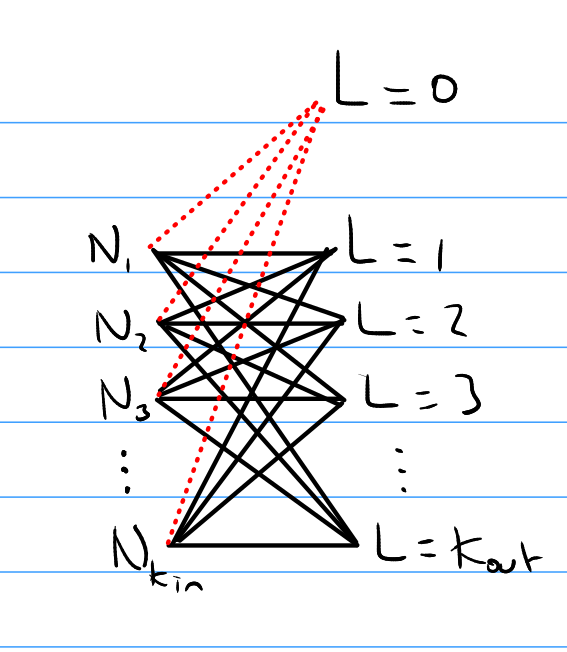

Effectively, each nymph has its contact network that is equal to the number of larva that nymph co-aggregates with. The transmission between nymph to larva (that becomes an infected nymph) can superimposed onto the contact network of each nymph. A nymph can have 0 larvae that it co-aggregates with, which would just be a single vertex with degree of 0.

Then for each vertebrate, or node in the network, and for each nymph on that vertebrate, record the $ k_{out} $ as the number of larvae that a single nymph co-aggregates with. Let these values form "co-aggregation data". We can then fit an appropriate distribution to that data. For brevity, below we rename $ k_{out} $ to be $ L $.

Not every co-aggregating larva becomes an infectious nymph. So, we can use the following stochastic process to generate an offspring distribution:

Let:

- `co-aggregation data` be a vector of larvae that co-aggregate with one or more nymphs, with one observation (vector element) per nymph
- $ n $ be the number of nymphs in the analysis, also the length of the `co-aggregation data`
- $ L_i \sim \text{NegBinom}(m, k) $ be the `co-aggregation distribution`, which is an appropriate fit to the `co-aggregation data`. The analysis below shows that NegBinom is an appropriate fit. $ L_i $ is the number of larvae that coaggregate with a nymph of index $ i $. Note that in parameterisation, $ m $ is equal to the `co-aggregation data` mean. The parameters $ m, k $ are asymptotic.
- $ m = \frac{1}{n} \sum_i^n L_i $, as stated above, the mean of the co-aggregation distribution
- $ c $ be the contact rate, or probability that co-aggregation occurs close enough for a nymph to transmit the pathogen to a larva.
- $ v $ be the probability of successfully transmitting the pathogen from nymph to larvae. This accounts for individual nymphal transmission competence.
- $ \sigma $ be the probability that an infected larvae survives to become a nymph (larval-to-nymphal moulting success).
- $ \alpha = \sigma v c $ be the overall probability that a larvae becomes an infectious nymph. In other words, a larvae that coaggregates with a nymph becomes an offspring.
- $ I_{i,j} \sim \text{Bern} $ be a bernoulli trial, or, a coin flip where the coin has $ \mu = \alpha $, for each nymph of index $ i $ and for each larvae that it co-aggregates with, indexed by $ j \in 1:L_i $
- $ Z \sim \text{NegBinom}(R_0, k) $ be the `offspring distribution`. By simulating offspring data, you can fit a NegBinom distribution to it. This is the same parameterisation as before and the simulated offspring data will have mean $ R_0 $.

Now we demonstrate that we don't need the simulaton.

To get the expected number of new infections for each nymph, dependent on the number of larvae that it co-aggregates with, the number of new infections is a series of bernoulli trials:

$ I_i = \sum_j^{L_i} I_{i,j} $, where $ L_i $ is the number of trials.

A series of bernoulli trials is otherwise known as a binomial experiment, and is represented by a biniomial distribution:

$ I_i \sim \text{Binom}(L_i,\alpha) $

The expected value of that binomial distribution is $ \mu_i = L_i \alpha $, which is the expected number of new infections for the nymph of index $ i $.

Then to determine $ R_0 $, which is the expected number of new infection (or offspring), this is:

$ R_0 = \frac{1}{n} \sum_i^n \mu_i $

$ R_0 = \frac{1}{n} \sum_i^n L_i \alpha $

$ R_0 = \alpha \frac{1}{n} \sum_i^n L_i $

$ R_0 = \alpha m $

That is good news, because the NegBinom parameterisation used in this analysis uses the sample mean as a parameter. The parameters $ m, k $ are asymptotic, meaning that changing the sample mean shouldn't affect the dispersion parameter $ k $.

So, to find the parameters for the offspring distribution, it is sufficient to fit the `co-aggregation distribution` to find $ k $, or the dispersion parameter, and then scale the mean value of the co-aggregation distribution: $ R_0 = \alpha m $

---

The first iteration of this analysis used a Monte Carlo simulation to generate simulated a offspring distribution. Then, the same analysis is completed using the analytic results obtained above.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
from scipy import stats
from math import factorial, gamma
from scipy.stats._distn_infrastructure import _ShapeInfo

font = {'size'   : 14}
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

In [2]:
from nbinom_reparameterisation import nbinom_reparam, get_nbinom_params

In [3]:
from coaggregation_offspring import get_coaggregation_per_nymph, simulate_offspring_data

In [4]:
from fitting import MLE, plot_goodness_of_fit

In [5]:
def get_alpha_threshold(m_c):
    return 1/m_c

alpha_threshold_summary = pd.DataFrame(columns=["Years", "Tick species", "Host species", "m", "Alpha threshold"])

### Analysis for selected data

In [6]:
def analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary):
    
    # FIND BEST COAGGREGATION DISTRIBUTION
    
    e_cdf = stats.ecdf(coaggregation_per_nymph)
    plot_goodness_of_fit(e_cdf, coaggregation_per_nymph, years_display, tick_species_display, host_species_display)
    
    # Graphically, which dist fits best?
    # For all data, it looks like the Poisson doesn't fit at all, and the nbinom is somewhat better than the geometric distribution.
    # It looks like the coaggregation data is fit by nbinom
    # Ideally, find a way to use this - https://journal.r-project.org/archive/2011/RJ-2011-016/RJ-2011-016.pdf
    
    # FIT COAGGREGATION DISTRIBUTION

    fitted_coaggregation_distribution = MLE(coaggregation_per_nymph, nbinom_reparam)
    fitted_coaggregation_distribution.plot()

    fitted_coaggregation_distribution_params = get_nbinom_params(fitted_coaggregation_distribution)
    plt.suptitle("Negative binomial distribution")
    plt.title("m = {0:.4f}, k = {1:.4f}".format(fitted_coaggregation_distribution_params.m,
                                            fitted_coaggregation_distribution_params.k))
    #plt.title("Ticks: {} & Vertebrates: {}".format(tick_species_display, host_species_display))
    plt.xlabel("Number of larvae co-feeding with this nymph")
    filename = "figs/coaggregation_dist_{}_{}_{}.png".format(years_display, tick_species_display, host_species_display).replace(" ", "").replace(",", "")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    
    # Use that as the co-aggregation distribution
    
    # FIND OFFSPRING DISTRIBUTION

    print("Probability that an infected larvae becomes an infectious nymph: {0:.4f}".format(alpha))
    offspring_distribution_m = fitted_coaggregation_distribution_params.m * alpha
    offspring_distribution_k = fitted_coaggregation_distribution_params.k
    print("Years: {} & Ticks: {} & Vertebrates: {}".format(years_display, tick_species_display, host_species_display))
    print("Offspring distribution: NBinom, R_0~{0:.4f}, k~{1:.4f}".format(offspring_distribution_m,
                                                                          offspring_distribution_k))

    # SUMMARY FOR ALPHA THRESHOLDS

    alpha_threshold = get_alpha_threshold(fitted_coaggregation_distribution_params.m)
    alpha_threshold_summary.loc[len(alpha_threshold_summary)] = [years_display, 
                                                                 tick_species_display, 
                                                                 host_species_display, 
                                                                 fitted_coaggregation_distribution_params.m,
                                                                 alpha_threshold]

### Default $ \alpha $ estimates

In [7]:
# Illustrative only, since we will never know the actual value of $ \alpha $

sigma = 0.5 # Estimates for larval-nymphal survival range between 10% and 90%, see thesis for references
c = 0.4 # Since ticks go for ears, and there are usually two ears. But some ticks might also end up not on an ear at all
v = 0.95 # aribtrarily set to be not quite perfect
alpha = sigma*c*v

### NOTE: data years relabeled to 1=2004, 2=2005 in Excel, for ease...

### All species of tick and all vertebrate species, all years

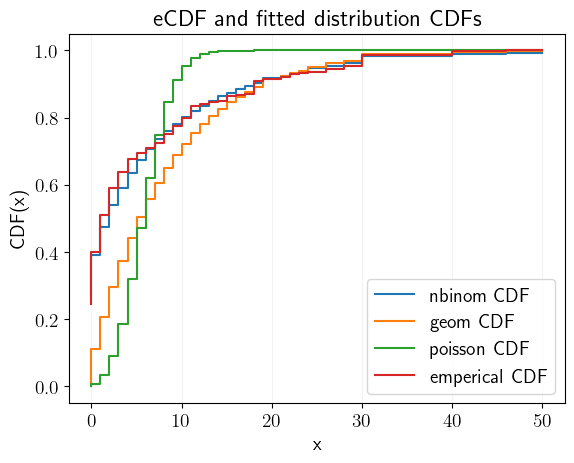

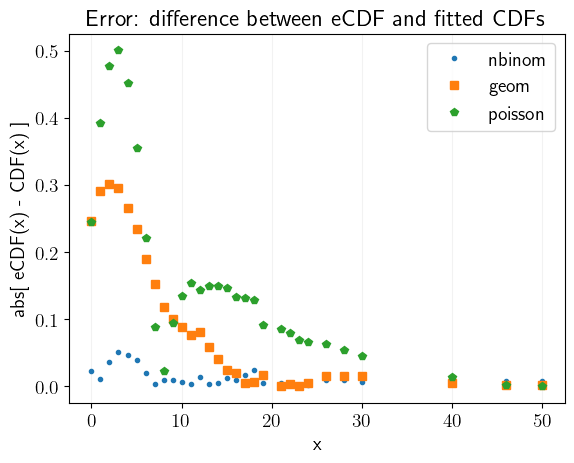

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 4955.487384209469
Geom scaled AIC: inf
NBinom scaled AIC: 2012.5414646502306


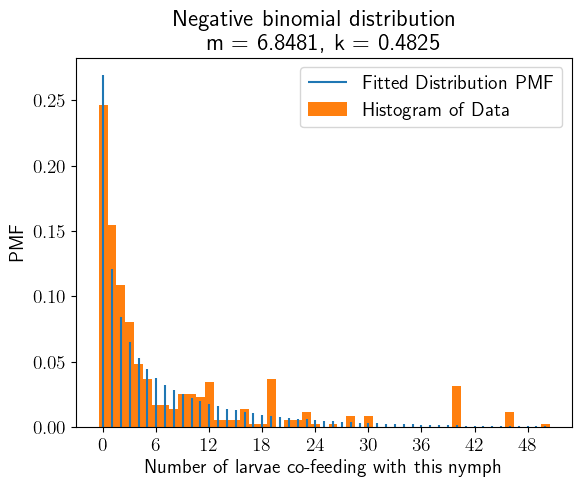

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2004, 2005 & Ticks: I. ricinus, I. trianguliceps & Vertebrates: SA, FV
Offspring distribution: NBinom, R_0~1.3011, k~0.4825


In [8]:
df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA") | (df["Species"] == "FV")]

tick_species_display = "I. ricinus, I. trianguliceps"
host_species_display = "SA, FV"
years_display = "2004, 2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=True, trianguliceps=True)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)

### Single species of tick on both species of hosts, all years

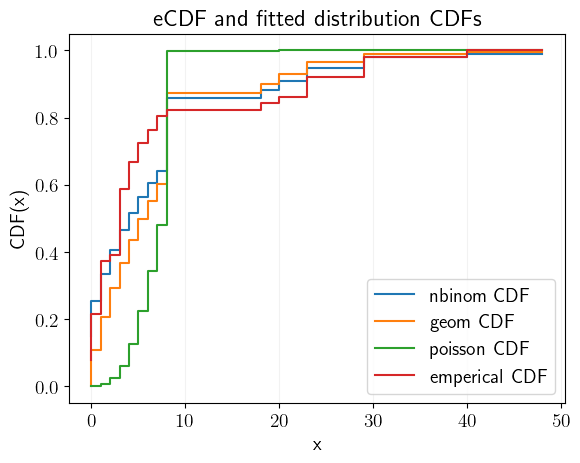

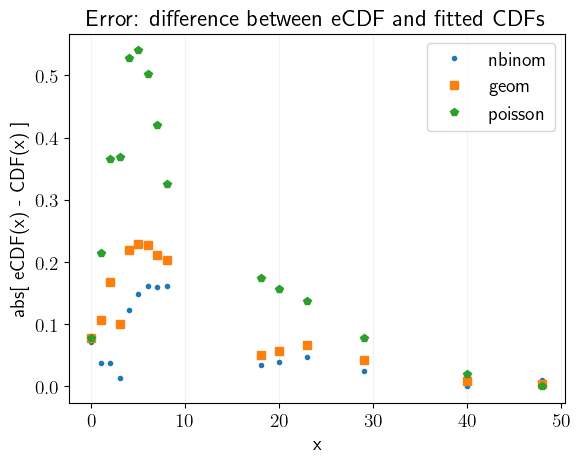

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 806.4207201820818
Geom scaled AIC: inf
NBinom scaled AIC: 331.6324741628206


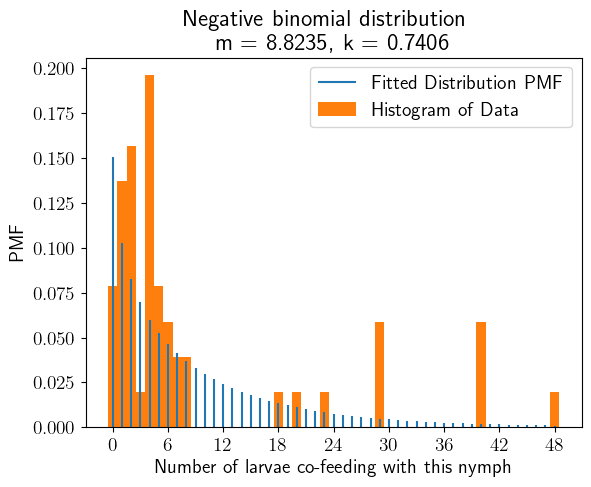

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2004, 2005 & Ticks: I. ricinus & Vertebrates: SA, FV
Offspring distribution: NBinom, R_0~1.6765, k~0.7406


In [9]:
# I.ricinus, SA and FV

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA") | (df["Species"] == "FV")]

tick_species_display = "I. ricinus"
host_species_display = "SA, FV"
years_display = "2004, 2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=True, trianguliceps=False)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


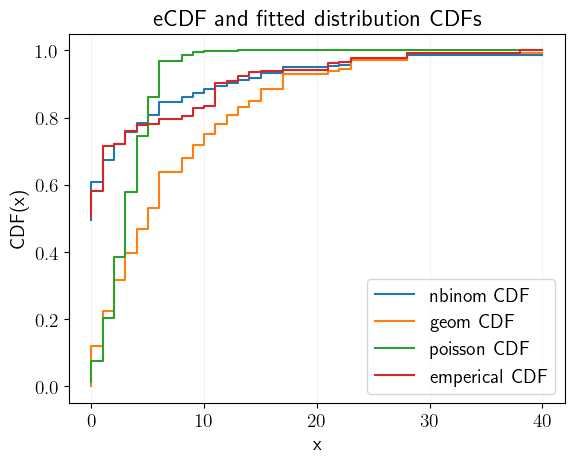

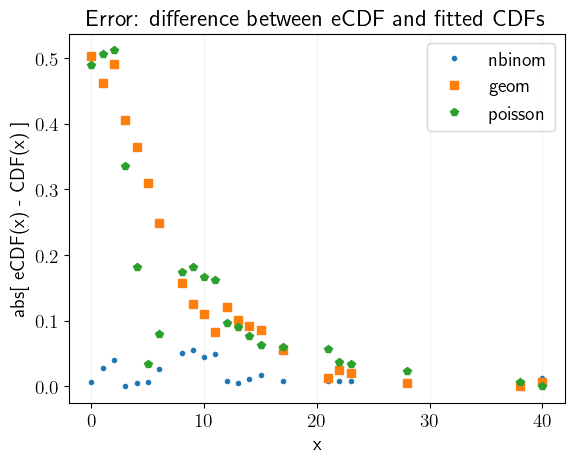

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 3544.031648202937
Geom scaled AIC: inf
NBinom scaled AIC: 1318.274856344429


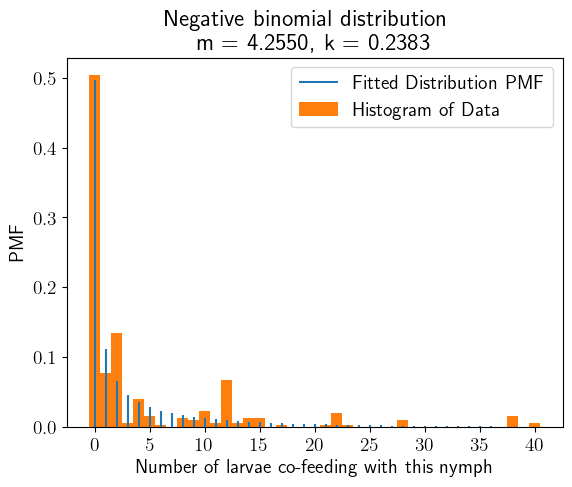

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2004, 2005 & Ticks: I. trianguliceps & Vertebrates: SA, FV
Offspring distribution: NBinom, R_0~0.8085, k~0.2383


In [10]:
# I.trianguliceps, SA and FV

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA") | (df["Species"] == "FV")]

tick_species_display = "I. trianguliceps"
host_species_display = "SA, FV"
years_display = "2004, 2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=False, trianguliceps=True)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


### Per year, per host species, per tick species

Exclude:
- 2004, FV, I. trianguliceps
- 2004, FV, I. ricinus
- 2005, SA, I. ricinus

Therefore, we keep:
- 2004, SA, I. ricinus
- 2004, SA, I. trianguliceps
- 2005, FV, I. ricinus
- 2005, SA, I. trianguliceps
- 2005, FV, I. trianguliceps

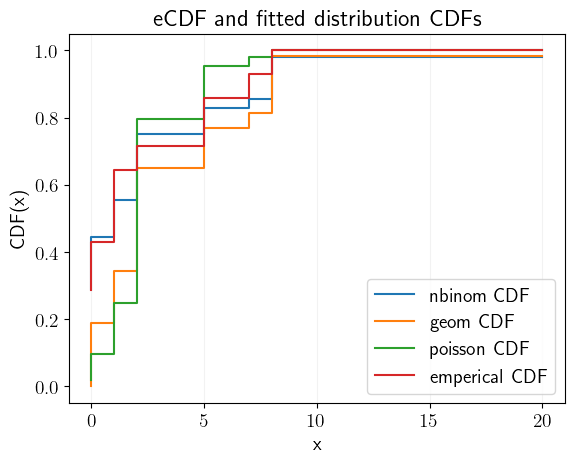

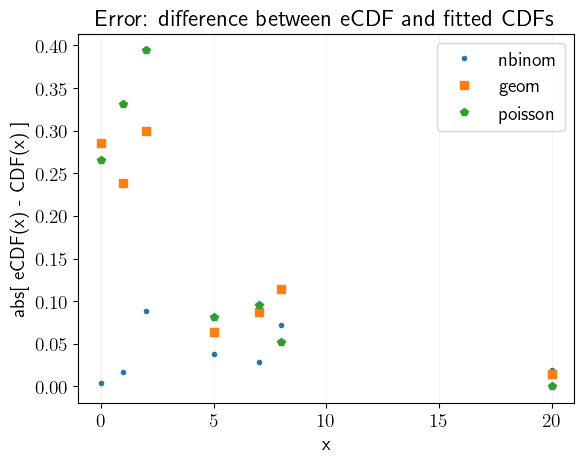

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 115.53793995562397
Geom scaled AIC: inf
NBinom scaled AIC: 73.72454328432181


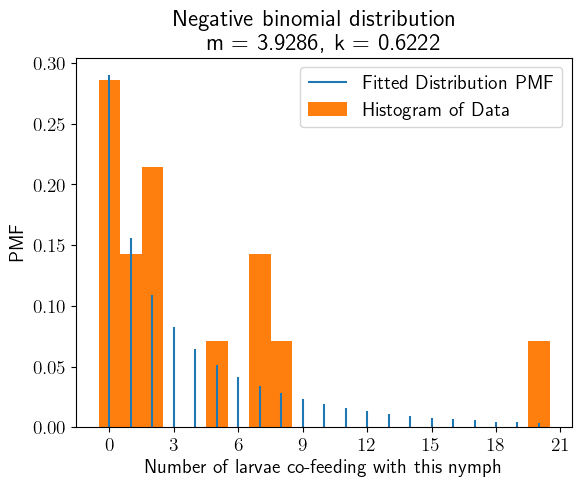

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2004 & Ticks: I. ricinus & Vertebrates: SA
Offspring distribution: NBinom, R_0~0.7464, k~0.6222


In [11]:
# 2004, SA, I. ricinus

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA")]
data = data[data["Year"] == 2004]

tick_species_display = "I. ricinus"
host_species_display = "SA"
years_display = "2004"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=True, trianguliceps=False)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)

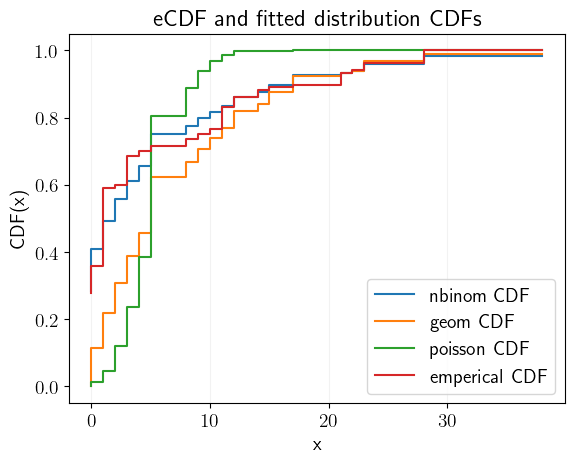

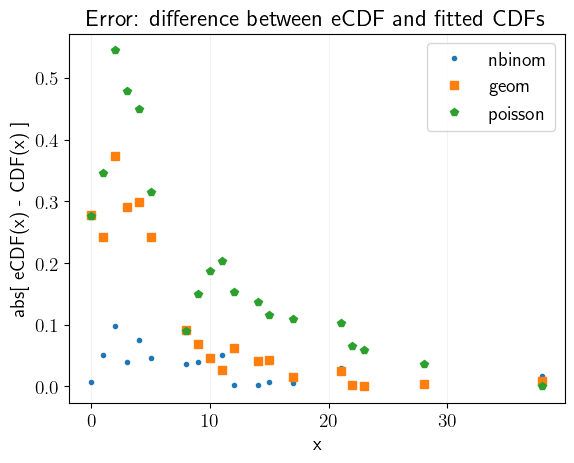

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 1811.5401972702668
Geom scaled AIC: inf
NBinom scaled AIC: 773.6340345957367


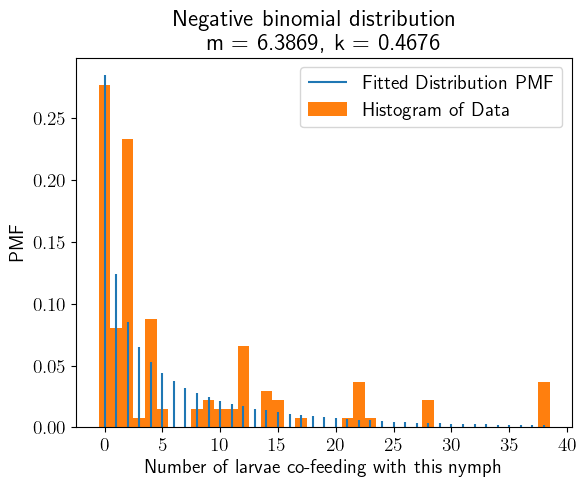

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2004 & Ticks: I. trianguliceps & Vertebrates: SA
Offspring distribution: NBinom, R_0~1.2135, k~0.4676


In [12]:
# 2004, SA, I. trianguliceps

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA")]
data = data[data["Year"] == 2004]

tick_species_display = "I. trianguliceps"
host_species_display = "SA"
years_display = "2004"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=False, trianguliceps=True)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


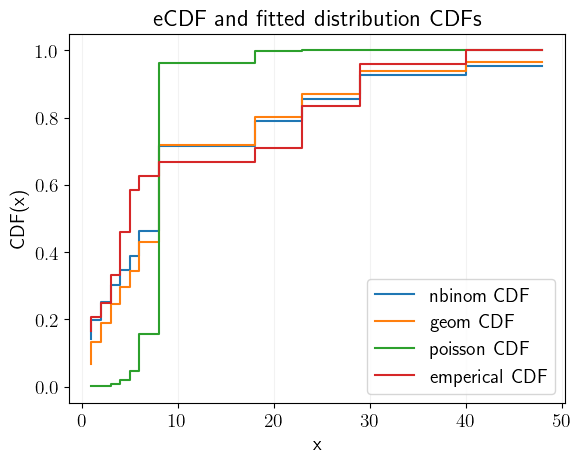

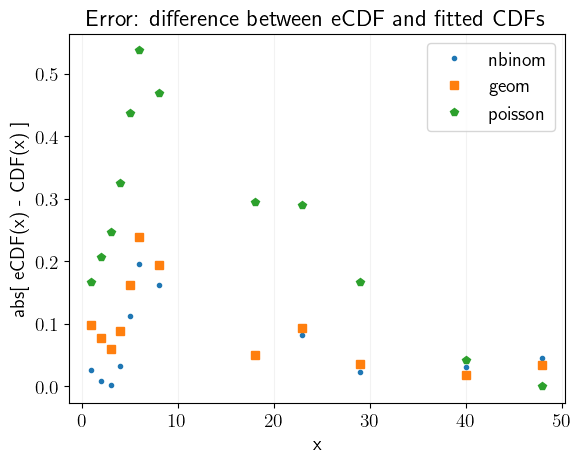

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 471.77776322674083
Geom scaled AIC: 176.69630609709415
NBinom scaled AIC: 182.2054570315875


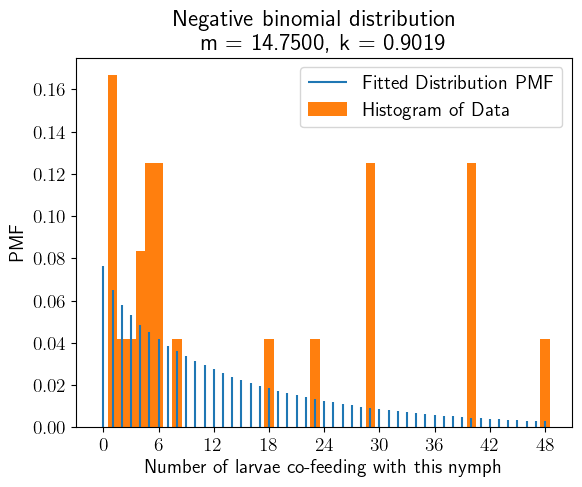

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2005 & Ticks: I. ricinus & Vertebrates: FV
Offspring distribution: NBinom, R_0~2.8025, k~0.9019


In [13]:
# 2005, FV, I. ricinus

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "FV")]
data = data[data["Year"] == 2005]

tick_species_display = "I. ricinus"
host_species_display = "FV"
years_display = "2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=True, trianguliceps=False)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


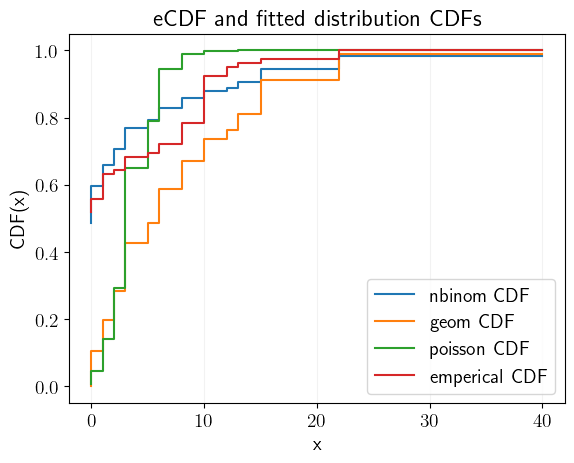

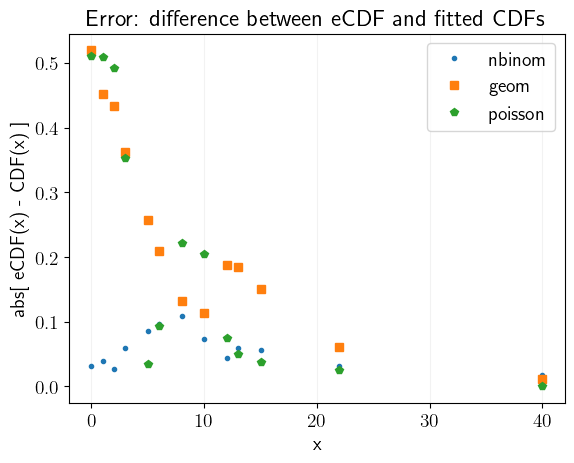

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 939.5002778344196
Geom scaled AIC: inf
NBinom scaled AIC: 370.8018331177667


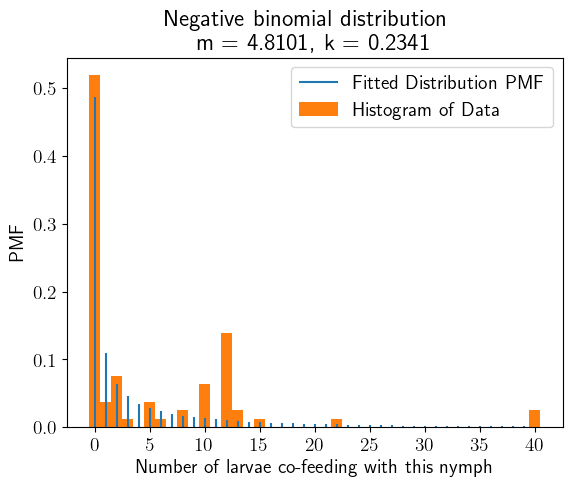

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2005 & Ticks: I. trianguliceps & Vertebrates: SA
Offspring distribution: NBinom, R_0~0.9139, k~0.2341


In [14]:
# 2005, SA, I. trianguliceps

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "SA")]
data = data[data["Year"] == 2005]

tick_species_display = "I. trianguliceps"
host_species_display = "SA"
years_display = "2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=False, trianguliceps=True)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


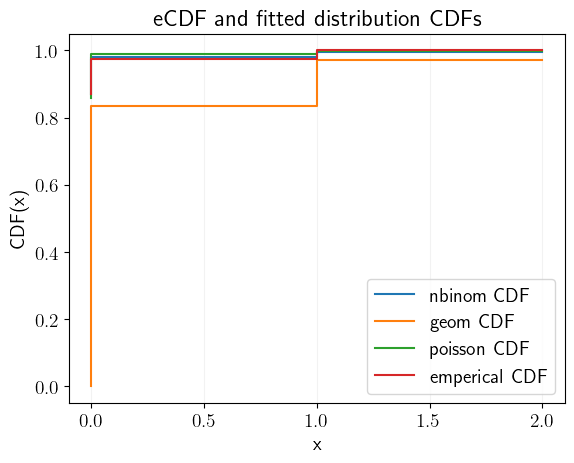

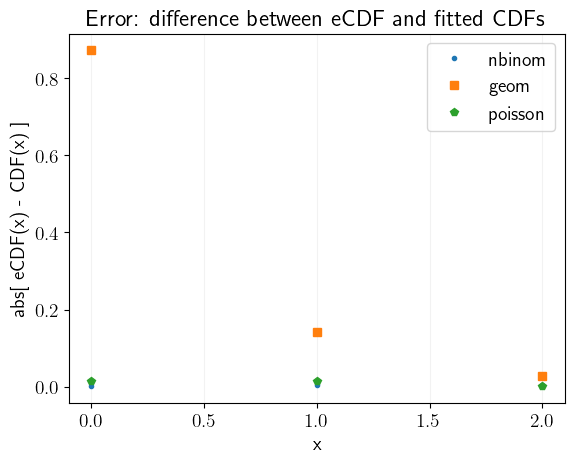

AIC OF CO-AGGREGATION DISTRIBUTIONS
Poisson scaled AIC: 73.74847254682533
Geom scaled AIC: inf
NBinom scaled AIC: 74.76850333708246


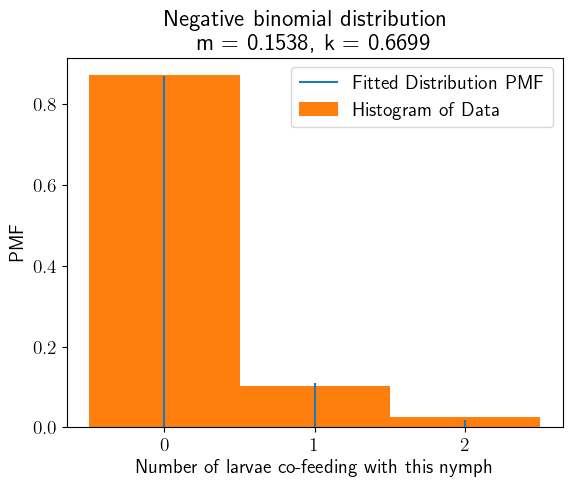

Probability that an infected larvae becomes an infectious nymph: 0.1900
Years: 2005 & Ticks: I. trianguliceps & Vertebrates: FV
Offspring distribution: NBinom, R_0~0.0292, k~0.6699


In [15]:
# 2005, FV, I. trianguliceps

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')

data = df[(df["Species"] == "FV")]
data = data[data["Year"] == 2005]

tick_species_display = "I. trianguliceps"
host_species_display = "FV"
years_display = "2005"

coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=False, trianguliceps=True)

analysis_for_selected_data(alpha, coaggregation_per_nymph, years_display, tick_species_display, host_species_display, alpha_threshold_summary)


In [16]:
print("ALPHA THRESHOLD THAT IS NECESSARY, BUT NOT SUFFICIENT, FOR PATHOGEN PERSISTENCE")
print(alpha_threshold_summary)

ALPHA THRESHOLD THAT IS NECESSARY, BUT NOT SUFFICIENT, FOR PATHOGEN PERSISTENCE
        Years                  Tick species Host species          m  \
0  2004, 2005  I. ricinus, I. trianguliceps       SA, FV   6.848138   
1  2004, 2005                    I. ricinus       SA, FV   8.823529   
2  2004, 2005              I. trianguliceps       SA, FV   4.255034   
3        2004                    I. ricinus           SA   3.928571   
4        2004              I. trianguliceps           SA   6.386861   
5        2005                    I. ricinus           FV  14.750000   
6        2005              I. trianguliceps           SA   4.810127   
7        2005              I. trianguliceps           FV   0.153846   

   Alpha threshold  
0         0.146025  
1         0.113333  
2         0.235016  
3         0.254545  
4         0.156571  
5         0.067797  
6         0.207895  
7         6.500000  


### Demonstration that parameterisation's parameters are asymptotic

Lloyd-Smith et al said:

    For the negative binomial distribution, the dispersion parameter k is asymptotically orthogonal to the mean and so is estimated independently after substituting the ML estimate of the mean into the likelihood expression.

I wanted to convince myself this was true, so I made the following code: it runs through experiments to fit offspring distributions to simulated data. The mean of $ R_0, k $ and recorded for all experiments. We can expect those aggregated results to be very similar to an offspring distribution where $ R_0 = \alpha m $, and $ k $ is the same as the co-aggregation distribution.

Note: Scipy might complain about an infinite loop. replace `raise RuntimeError('updating stopped, endless loop')` with `pass`. This is a hack for sure, but only used to demonstrate this one point


In [17]:
def demonstration_asymptotic_params(coaggregation_per_nymph):
    # Mock values
    sigma = 0.8
    c = 0.6
    v = 0.5
    alpha = sigma*c*v
    
    summary = pd.DataFrame(columns=["source", "m", "k"])

    # The co-aggregation distribution relies on the data directly without a stochastic step
    fitted_coaggregation_distribution = MLE(coaggregation_per_nymph, nbinom_reparam)
    fitted_coaggregation_distribution_params = get_nbinom_params(fitted_coaggregation_distribution)
    summary.loc[len(summary)] = ["co-aggregation distribution", fitted_coaggregation_distribution_params.m, fitted_coaggregation_distribution_params.k]
    summary.loc[len(summary)] = ["offspring distribution (scaled mean)", fitted_coaggregation_distribution_params.m * alpha, fitted_coaggregation_distribution_params.k]

    simulated_m = []
    simulated_k = []
    for i in range(0,200):
        if i % 20 == 0:
            print("Experiment #{0}".format(i))
        offspring_simulated = simulate_offspring_data(alpha, fitted_coaggregation_distribution_params, simulation_size=2000, report=False)    
        fitted_offspring_distribution = MLE(offspring_simulated, nbinom_reparam)
        fitted_offspring_distribution_params = get_nbinom_params(fitted_offspring_distribution)
        simulated_m.append(fitted_offspring_distribution_params.m)
        simulated_k.append(fitted_offspring_distribution_params.k)

    summary.loc[len(summary)] = ["offspring distribution (aggregated simulations)", np.mean(simulated_m), np.mean(simulated_k)]
    return summary

df = pd.read_excel(open('Kielder_data_NGM.xlsx', 'rb'),
              sheet_name='Burden Data')
data = df[(df["Species"] == "SA") | (df["Species"] == "FV")]
coaggregation_per_nymph = get_coaggregation_per_nymph(data, ricinus=True, trianguliceps=True)
print(demonstration_asymptotic_params(coaggregation_per_nymph))

Experiment #0


KeyboardInterrupt: 

This helps me believe the earlier analytic result is correct. Now remove the hack and re-run all other cells.